In [234]:
using CSV, JSON, DataFrames, HTTP, Format, Downloads, Statistics, Plots, StatsBase

BMU_LIST_URL = "https://data.elexon.co.uk/bmrs/api/v1/reference/bmunits/all"
BOD_URL = "https://data.elexon.co.uk/bmrs/api/v1/balancing/bid-offer?bmUnit={1}&from={2}&to={3}&format=csv"
PN_URL = "https://data.elexon.co.uk/bmrs/api/v1/balancing/physical?bmUnit={1}&from={2}&to={3}&dataset=PN&format=csv"
QUERY_DATE_FROM = "2025-09-20T00%3A00Z"
QUERY_DATE_TO = "2025-09-27T00%3A00Z"
HIGH_OFFER_FILTER = 250 # ignore offer prices above this - BMUs pricing themselves out of BM?

# function to filter for bmus of interest
function bmu_filter(fuelType, generationCapacity)::Bool
    is_CCGT = fuelType == "CCGT"
    if isnothing(generationCapacity)
        is_active = false
    else
        is_active = parse(Float64, generationCapacity) > 0
    end
    is_CCGT && is_active
end

# functions to identify PNs at low and high points
function pn_filter_low(LevelFrom, LevelTo)::Bool
    LevelFrom == 0 && LevelTo == 0
end

function pn_filter_high(capacity)
    return function(LevelFrom, LevelTo)
        LevelFrom > parse(Float64,capacity)/2 && LevelTo > parse(Float64,capacity)/2
    end
end

# Vectors to store offer prices
low_offers =  Vector{Float64}()
high_offers =  Vector{Float64}()
no_generators = 0

0

In [244]:
# get list of BMUs
r = HTTP.get(BMU_LIST_URL);
bmu_df = DataFrame(JSON.parse(String(r.body)))
first(bmu_df,5)

Row,nonWorkingDayCreditAssessmentExportCapability,bmUnitName,fpnFlag,transmissionLossFactor,nationalGridBmUnit,workingDayCreditAssessmentExportCapability,nonWorkingDayCreditAssessmentImportCapability,demandInProductionFlag,bmUnitType,gspGroupId,fuelType,workingDayCreditAssessmentImportCapability,interconnectorId,creditQualifyingStatus,leadPartyName,elexonBmUnit,productionOrConsumptionFlag,eic,generationCapacity,gspGroupName,demandCapacity,leadPartyId
,Union…,Union…,Union…,Union…,String,Union…,Union…,Bool,Union…,Union…,Union…,Union…,Union…,Bool,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…
1,6.160,Aberdare Power Station,true,0.0162007,ABERU-1,6.160,0.000,false,E,_K,,0.000,,true,UK Power Reserve Limited,E_ABERDARE,C,,15.400,South Wales,0.000,UKPR
2,39.600,ABRBO-1,true,-0.0301340,ABRBO-1,39.600,-0.800,false,T,,WIND,-0.800,,true,Aberdeen Offshore Wind Farm,T_ABRBO-1,P,48W00000ABRBO-19,99.000,,-2.000,ABERDEEN
3,14.400,Auchrobert Wind Farm,true,-0.0088069,ABRTW-1,14.400,-4.000,false,E,_N,WIND,-4.000,,true,Npower Commercial Gas Limited,E_ABRTW-1,C,48W00000ABRTW-1Z,36.000,South Scotland,-10.000,NPOWER02
4,3.186,C__PSMAR001-AAA-ACH-183,true,-0.0301340,ACHLW-1,3.186,0.000,false,S,_P,WIND,0.000,,false,Smartestenergy Limited,C__PSMAR001,C,,9.978,North Scotland,0.000,SMARTEST
5,17.040,AChruach Wind Farm,true,-0.0301340,ACHRW-1,17.040,-0.800,false,T,,WIND,-0.800,,true,Mobius Renewables Gen. (GB2,T_ACHRW-1,P,48W00000ACHRW-1O,42.600,,-2.000,AIRGEN2


In [235]:
# for each BMU that meets filtering criteria
# fetch the offer data for the requested time period
# fetch the PN data for the requested time period
# filter the offer data by high and low PNs
# append the two offer datasets to the combined pan-BMU dataset

for x in eachrow(filter([:fuelType, :generationCapacity] => bmu_filter, bmu_df))
    print(x.elexonBmUnit, " ", x.generationCapacity, " ")
    r = CSV.File(Downloads.download(format(BOD_URL, x.elexonBmUnit, QUERY_DATE_FROM, QUERY_DATE_TO)))
    bmu_bids_df = DataFrame(r)
    if nrow(bmu_bids_df)>0
        r = CSV.File(Downloads.download(format(PN_URL, bmu_id, QUERY_DATE_FROM, QUERY_DATE_TO)))
        bmu_pn_df = DataFrame(r)
        if nrow(bmu_pn_df)>0
            pn_low_periods = filter([:LevelFrom, :LevelTo] => pn_filter_low, bmu_pn_df)[:,["SettlementDate", "SettlementPeriod"]]
            pn_high_periods = filter([:LevelFrom, :LevelTo] => pn_filter_high(x.generationCapacity), bmu_pn_df)[:,["SettlementDate", "SettlementPeriod"]]
            if (nrow(pn_low_periods)>0 && nrow(pn_high_periods)>0)
                global bids_filtered_low = filter(row -> row.PairId == 1, innerjoin(bmu_bids_df, pn_low_periods, on=[:SettlementDate, :SettlementPeriod]))[:,[:Offer]]
                global bids_filtered_high = filter(row -> row.PairId == 1, innerjoin(bmu_bids_df, pn_high_periods, on=[:SettlementDate, :SettlementPeriod]))[:,[:Offer]]
                if nrow(bids_filtered_low)>0
                    append!(low_offers, bids_filtered_low[:,1])
                end
                if nrow(bids_filtered_high)>0
                    append!(high_offers, bids_filtered_high[:,1])
                end
                no_generators += 1
            end
        end
    end
end

T_BAGE-1 500.000 T_BAGE-2 32.000 E_BRGG-1 50.000 T_CARR-1 470.000 T_CARR-2 470.000 T_CDCL-1 445.000 T_CNQPS-1 351.162 T_CNQPS-2 352.000 T_CNQPS-3 350.000 T_CNQPS-4 356.000 E_CORB-1 240.000 T_COSO-1 800.000 T_DAMC-1 820.000 T_DIDCB5 770.000 T_DIDCB6 720.000 T_EECL-1 444.000 E_FAWN-1 155.000 E_FELL-1 140.000 T_GRAI-6 468.000 T_GRAI-7 468.000 T_GRAI-8 468.000 T_GRMO-1 144.000 E_GYAR-1 420.000 T_HUMR-1 1283.000 T_KEAD-1 764.000 T_KEAD-2 890.000 T_KILLPG-1 311.000 T_KILLPG-2 316.000 E_KLYN-A-1 392.000 T_LAGA-1 905.000 T_LBAR-1 750.000 T_MEDP-1 750.000 T_MRWD-1 920.000 T_PEHE-1 1200.000 T_PEMB-11 475.000 T_PEMB-21 475.000 T_PEMB-31 475.000 T_PEMB-41 475.000 T_PEMB-51 475.000 E_PETEM1 245.000 T_ROCK-1 810.000 T_RYHPS-1 720.980 T_SCCL-1 408.200 T_SCCL-2 409.100 T_SCCL-3 409.300 T_SEAB-1 830.000 T_SEAB-2 406.000 T_SHBA-1 821.400 T_SHBA-2 580.000 E_SHOS-1 460.000 T_SPLN-1 950.000 T_STAY-1 464.000 T_STAY-2 464.000 T_STAY-3 464.000 T_STAY-4 464.000 T_SUTB-1 850.000 T_SVRP-10 425.000 T_SVRP-20 425.

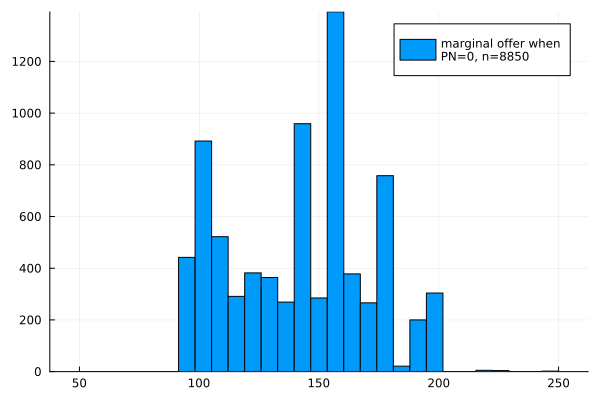

In [248]:
b_range = range(50, 250, length=30)
histogram(filter(x-> x<HIGH_OFFER_FILTER, low_offers), bins=b_range,  label=string("marginal offer when \nPN=0, n=", size(low_offers)[1]))

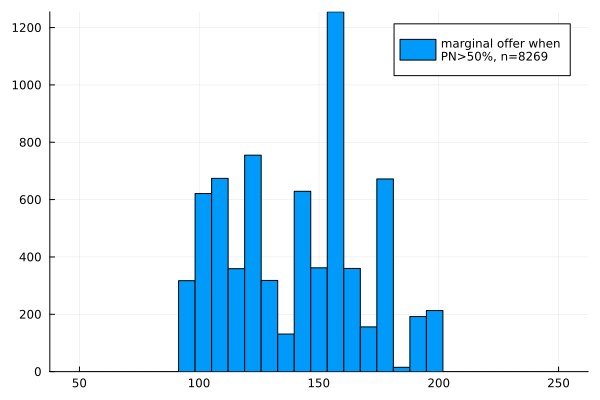

In [246]:
histogram(filter(x-> x<HIGH_OFFER_FILTER, high_offers), bins=b_range, label=string("marginal offer when \nPN>50%, n=", size(high_offers)[1]))

In [238]:
describe(filter(x-> x<HIGH_OFFER_FILTER, low_offers))

Summary Stats:
Length:         7736
Missing Count:  0
Mean:           142.343495
Std. Deviation: 29.249087
Minimum:        92.500000
1st Quartile:   114.500000
Median:         145.000000
3rd Quartile:   161.000000
Maximum:        249.000000
Type:           Float64


In [239]:
describe(filter(x-> x<HIGH_OFFER_FILTER, high_offers))

Summary Stats:
Length:         7029
Missing Count:  0
Mean:           140.524036
Std. Deviation: 27.958821
Minimum:        92.500000
1st Quartile:   114.950000
Median:         145.000000
3rd Quartile:   160.000000
Maximum:        200.000000
Type:           Float64


In [208]:
no_generators

56